In [1]:
import rasterio
import numpy as np
import os
from datetime import datetime

def calc_fm(image):
    return 1.5 * image  # Applying flood mapping calculation

def load_tiff(filename):
    with rasterio.open(filename) as src:
        return src.read(1), src.profile

def save_tiff(output_filename, data, profile):
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open(output_filename, 'w', **profile) as dst:
        dst.write(data.astype(rasterio.float32), 1)

def evaluate_flood(before_vv, after_vv):
    before_fm = calc_fm(before_vv)
    after_fm = calc_fm(after_vv)
    flood_mask = (before_fm - after_fm) > 0.05
    return flood_mask.astype(np.uint8)

def process_folder(before_image_path, after_folder, output_folder):
    # Load the before image (assumed to be the same for all after images)
    before_vv, profile = load_tiff(before_image_path)
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Process each after image in the folder
    for filename in os.listdir(after_folder):
        if filename.endswith(".tiff") or filename.endswith(".tif"):
            after_image_path = os.path.join(after_folder, filename)
            after_vv, _ = load_tiff(after_image_path)
            
            # Evaluate flood mapping
            flood_mask = evaluate_flood(before_vv, after_vv)
            
            # Save the result with a unique filename
            output_filename = os.path.join(output_folder, f"flood_mask_{filename}")
            save_tiff(output_filename, flood_mask, profile)
            print(f"Processed and saved: {output_filename}")
    
    print("Flood mapping process completed for all images.")

if __name__ == "__main__":
    before_image = "o/2024-08-30.tiff"  # Path to the before image
    after_folder = "o"  # Folder containing after images
    output_folder = "o/output_masks"  # Folder to save results
    
    process_folder(before_image, after_folder, output_folder)


Processed and saved: o/output_masks/flood_mask_2024-08-30.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-06.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-03.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-08.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-23.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-20.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-15.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-11.tiff
Processed and saved: o/output_masks/flood_mask_2024-09-18.tiff
Flood mapping process completed for all images.


In [14]:
import os
import numpy as np
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
import scipy.ndimage as ndi

# Set the folder path containing TIFF files
folder_path = "path/to/your/tiff/folder"  # Change this to your folder path

# Threshold for considering a pixel as "white"
WHITE_THRESHOLD = 0.95  # Adjust based on your image intensity range

# Function to analyze TIFF images
def analyze_tiff_images(folder_path):
    results = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            file_path = os.path.join(folder_path, filename)
            image = tiff.imread(file_path)
            
            # Normalize image (assuming 32-bit TIFF with values between 0-1 or 0-65535)
            if image.dtype == np.uint16:
                image = image / 65535.0  # Convert to 0-1 range
            elif image.dtype == np.uint8:
                image = image / 255.0
            
            # Convert to grayscale if it has multiple channels
            if len(image.shape) == 3:
                image = np.mean(image, axis=-1)  # Averaging channels
            
            # Compute percentage of white area
            white_pixels = np.sum(image >= WHITE_THRESHOLD)
            total_pixels = image.size
            white_area_percentage = (white_pixels / total_pixels) * 100
            
            # Compute clustering using connected components
            labeled_img, num_clusters = label(image >= WHITE_THRESHOLD, return_num=True)
            cluster_sizes = [region.area for region in regionprops(labeled_img)]
            avg_cluster_size = np.mean(cluster_sizes) if cluster_sizes else 0
            
            # Compute density of clusters
            cluster_density = num_clusters / total_pixels
            
            # Store results
            results.append({
                "Filename": filename,
                "% White Area": white_area_percentage,
                "Number of Clusters": num_clusters,
                "Avg Cluster Size": avg_cluster_size,
                "Cluster Density": cluster_density,
            })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # Display the DataFrame
    
    # tools.display_dataframe_to_user(name="TIFF Analysis Results", dataframe=df_results)
    
    return df_results  # Ensure function returns DataFrame for later use

# Call the function
df = analyze_tiff_images("o/output_masks/")


In [15]:
df.head()

,Filename,% White Area,Number of Clusters,Avg Cluster Size,Cluster Density
0,flood_mask_2024-09-06.tiff,41.340842,54171,26.729486,0.015466
1,flood_mask_2024-09-11.tiff,23.591378,82511,10.014277,0.023558
2,flood_mask_2024-08-30.tiff,0.000000,0,0.000000,0.000000
3,flood_mask_2024-09-20.tiff,22.153519,74577,10.404374,0.021293
4,flood_mask_2024-09-18.tiff,16.070207,90562,6.215179,0.025856


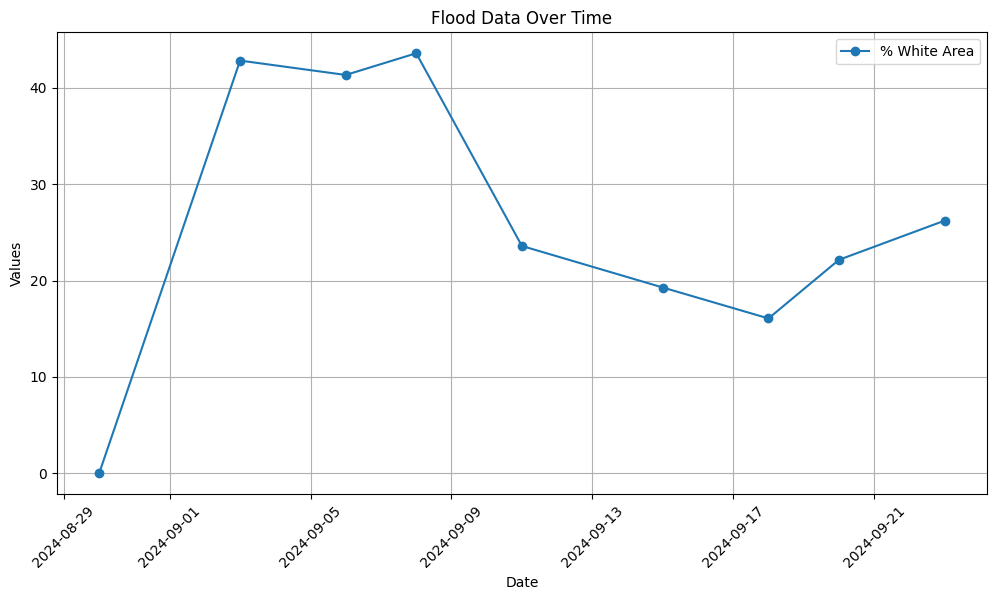

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

# Extract date from filename
def extract_date(filename):
    match = re.search(r"\d{4}-\d{2}-\d{2}", filename)
    return datetime.strptime(match.group(), "%Y-%m-%d") if match else None

df["Date"] = df["Filename"].apply(extract_date)

# Sort dataframe by date
df = df.sort_values("Date")

# Plot data
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["% White Area"], marker="o", label="% White Area")


plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Flood Data Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

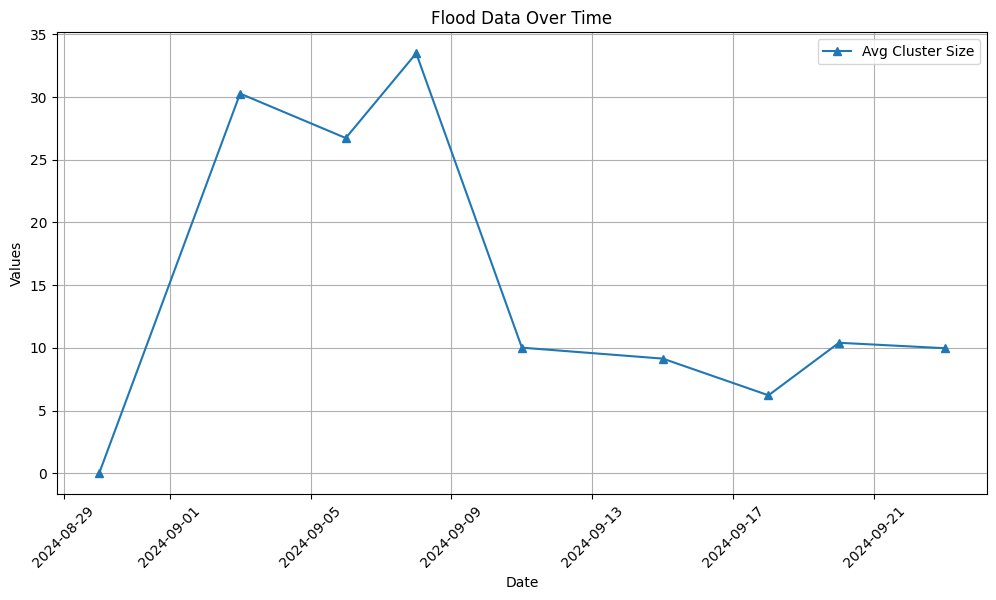

In [20]:
# Plot data
plt.figure(figsize=(12, 6))

plt.plot(df["Date"], df["Avg Cluster Size"], marker="^", label="Avg Cluster Size")


plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Flood Data Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

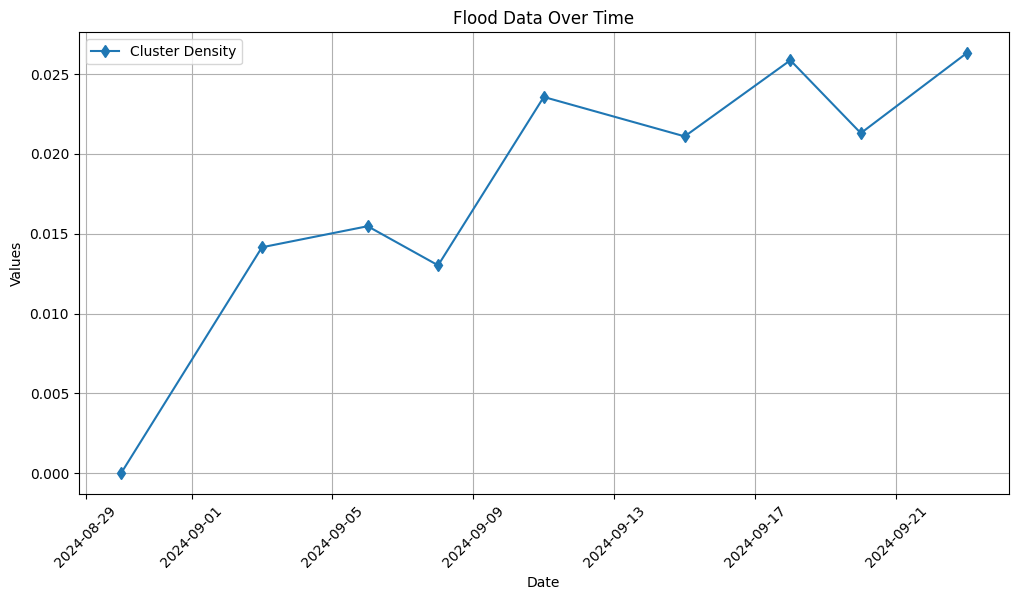

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

# Extract date from filename
def extract_date(filename):
    match = re.search(r"\d{4}-\d{2}-\d{2}", filename)
    return datetime.strptime(match.group(), "%Y-%m-%d") if match else None

df["Date"] = df["Filename"].apply(extract_date)

# Sort dataframe by date
df = df.sort_values("Date")

# Plot data
plt.figure(figsize=(12, 6))

plt.plot(df["Date"], df["Cluster Density"], marker="d", label="Cluster Density")

plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Flood Data Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [34]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from scipy.stats import skew, kurtosis

def compute_tiff_indicators(file_path):
    """Compute statistical, texture, and edge-based indicators for a TIFF image."""
    
    # Load the TIFF image
    image = tiff.imread(file_path).astype(np.float32)

    # Normalize if necessary
    if image.dtype == np.uint16:
        image /= 65535.0
    elif image.dtype == np.uint8:
        image /= 255.0

    # Convert to grayscale if multi-channel
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)

    # Compute indicators
    indicators = {
        "Mean Intensity": np.mean(image),
        "Median Intensity": np.median(image),
        "Std Dev Intensity": np.std(image),
        "Skewness": skew(image.flatten()),
        "Kurtosis": kurtosis(image.flatten()),
        "Entropy": shannon_entropy(image),
        "Edge Density": np.mean(sobel(image)),
    }
    
    return indicators

def process_tiff_folder(folder_path):
    """Process all TIFF files in a folder and compile results."""
    
    results = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            file_path = os.path.join(folder_path, filename)
            
            # Extract date from filename
            date_str = filename.split("_")[-1].split(".")[0]  # Extract date part
            try:
                date = pd.to_datetime(date_str)
            except:
                continue  # Skip files with invalid date format
            
            # Compute indicators
            indicators = compute_tiff_indicators(file_path)
            indicators["Date"] = date
            indicators["Filename"] = filename
            
            results.append(indicators)
    
    # Create DataFrame
    df_results = pd.DataFrame(results)
    
    # Sort by date
    df_results = df_results.sort_values("Date")
    
    return df_results

# Example usage
folder_path = "o/output_masks/"  # Change this to your folder path
df = process_tiff_folder(folder_path)




In [35]:
df = df.iloc[1:].reset_index(drop=True)


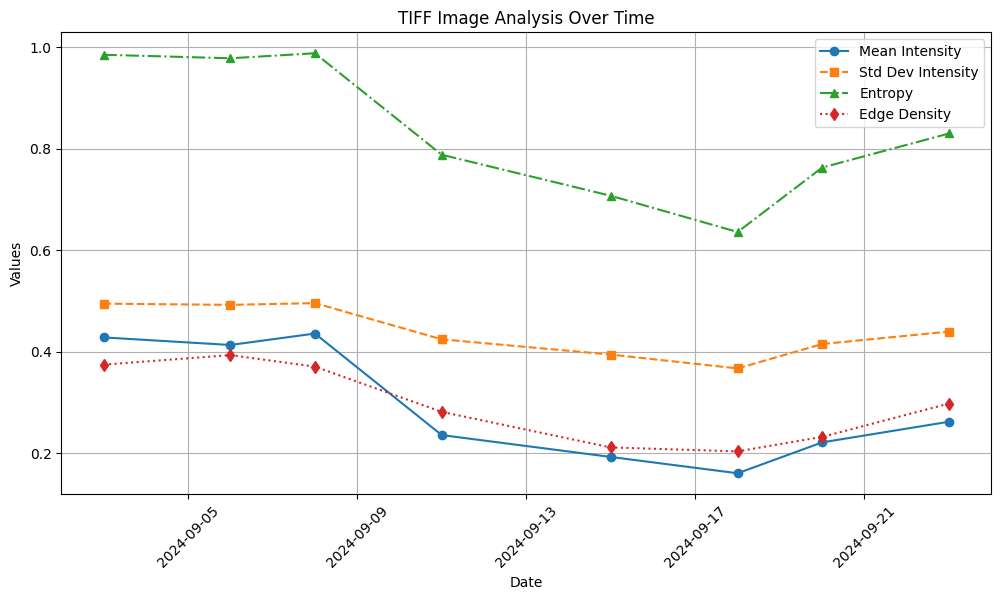

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_tiff_analysis(df):
    """Plots TIFF analysis indicators over time."""
    
    # Ensure Date column is in datetime format
    df["Date"] = pd.to_datetime(df["Date"])

    # Sort by date
    df = df.sort_values("Date")
    
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot different indicators
    plt.plot(df["Date"], df["Mean Intensity"], marker="o", linestyle="-", label="Mean Intensity")
    plt.plot(df["Date"], df["Std Dev Intensity"], marker="s", linestyle="--", label="Std Dev Intensity")
    plt.plot(df["Date"], df["Entropy"], marker="^", linestyle="-.", label="Entropy")
    plt.plot(df["Date"], df["Edge Density"], marker="d", linestyle=":", label="Edge Density")

    # Formatting
    plt.xlabel("Date")
   
    plt.ylabel("Values")
    plt.title("TIFF Image Analysis Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    # Show the plot
    plt.show()
# df1 = pd.read_csv("Modified_Data_with_Drop_on_2024-09-20.csv")
# Example usage
# df = pd.read_csv("your_dataframe.csv")  # Load your DataFrame if stored as a CSV
plot_tiff_analysis(df)


In [28]:
df.to_csv("pixel_stats_nysa.csv", index=False)


,Mean Intensity,Median Intensity,Std Dev Intensity,Skewness,Kurtosis,Entropy,Edge Density,Date,Filename
0,0.428335,0.0,0.494838,0.289650,-1.916103,0.985130,0.374616,2024-09-03,flood_mask_2024-09-03.tiff
1,0.413408,0.0,0.492445,0.351680,-1.876320,0.978256,0.393500,2024-09-06,flood_mask_2024-09-06.tiff
2,0.435945,0.0,0.495880,0.258347,-1.933257,0.988129,0.370746,2024-09-08,flood_mask_2024-09-08.tiff
3,0.235914,0.0,0.424569,1.244021,-0.452411,0.788179,0.281643,2024-09-11,flood_mask_2024-09-11.tiff
4,0.192794,0.0,0.394493,1.557471,0.425716,0.707280,0.211519,2024-09-15,flood_mask_2024-09-15.tiff
5,0.160702,0.0,0.367256,1.847746,1.414166,0.635986,0.203805,2024-09-18,flood_mask_2024-09-18.tiff
6,0.221535,0.0,0.415280,1.341095,-0.201464,0.762961,0.232379,2024-09-20,flood_mask_2024-09-20.tiff
7,0.262197,0.0,0.439829,1.081341,-0.830704,0.830044,0.298018,2024-09-23,flood_mask_2024-09-23.tiff


In [30]:
import pandas as pd

def remove_columns_from_csv(input_file, output_file, columns_to_remove):
    # Load the CSV file
    df = pd.read_csv(input_file)

    # Drop specified columns
    df.drop(columns=columns_to_remove, inplace=True, errors='ignore')
    df.info()
    # Save the modified DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

# Example usage
input_csv = "pixel_stats_nysa.csv"  # Replace with your input file
output_csv = "pixel_stats_nysa.csv"  # Replace with your output file
columns_to_remove = ["Filename"]  # Replace with column names to remove

remove_columns_from_csv(input_csv, output_csv, columns_to_remove)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mean Intensity     8 non-null      float64
 1   Median Intensity   8 non-null      float64
 2   Std Dev Intensity  8 non-null      float64
 3   Skewness           8 non-null      float64
 4   Kurtosis           8 non-null      float64
 5   Entropy            8 non-null      float64
 6   Edge Density       8 non-null      float64
 7   Date               8 non-null      object 
dtypes: float64(7), object(1)
memory usage: 640.0+ bytes


In [ ]:
df2=pd.read_csv("pixel_stats_nysa.csv")
# Combine the two DataFrames
# Add a column to identify the source file
df1["country"] = "cz"  # Replace "File1" with actual country name if known
df2["country"] = "pl"  # Replace "File2" with actual country name if known

# Combine
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save the combined dataset to a new CSV file
combined_df.to_csv("combined_pixel_stats.csv", index=False)

# Print confirmation
print("Combined CSV file saved as 'combined_tcrw.csv'")
